# Librerias

In [39]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

plt.style.use('fivethirtyeight')

# Data
Demanda energia en australia, varibles xogenas como la temp y si fue feriado

In [40]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
data=pd.read_csv(url)
data.head()


,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


# Exploracion del conjutno de datos

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [42]:
data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%dT%H:%M:%SZ')
data=data.set_index('Time')
data = data.asfreq('30min')
data=data.sort_index()
data.head()


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True


In [43]:
(data.index==pd.date_range(start=data.index[0],end=data.index.max(),freq=data.index.freq)).all()

True

In [44]:
data = data.drop('Date', axis=1)
data= data.resample(rule='H',closed='left',label='right').mean()
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [45]:
# Splitting data
data=data.loc['2012-01-01 00:00:00':'2014-12-30 00:00:00']
train_end = '2013-12-31 23:59:00'
test_end = '2014-11-30 23:59:00'
data_train = data.loc[: train_end,:]
data_test = data.loc[train_end:test_end,:]
data_val = data.loc[test_end:,:]
print(data_train.index.min(), data_train.index.max())
print(data_test.index.min(), data_test.index.max())
print(data_val.index.min(), data_val.index.max())


2012-01-01 00:00:00 2013-12-31 23:00:00
2014-01-01 00:00:00 2014-11-30 23:00:00
2014-12-01 00:00:00 2014-12-30 00:00:00


<Axes: xlabel='Time'>

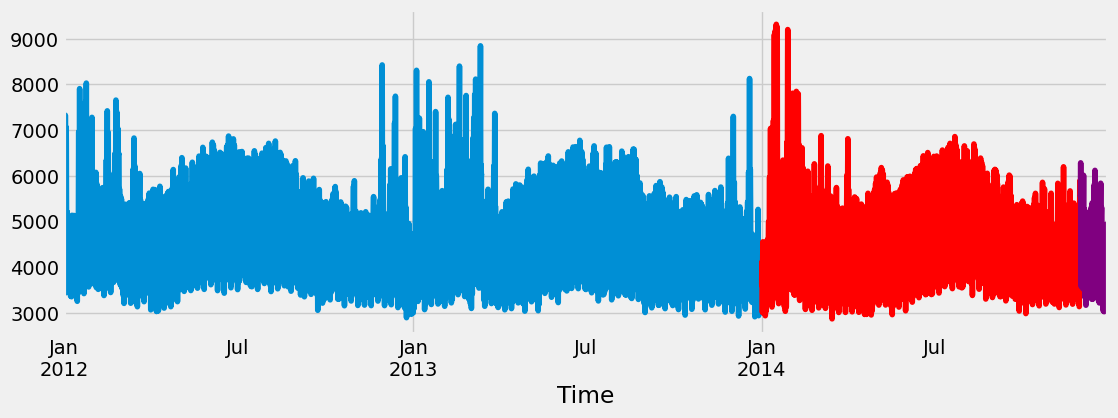

In [46]:
# Plot
fig, ax = plt.subplots(figsize=(12,4))
data_train.Demand.plot(ax=ax, label='Train')
data_test.Demand.plot(ax=ax, label='Test', color='red')
data_val.Demand.plot(ax=ax, label='Val', color='purple')



Text(0.5, 0.98, '')

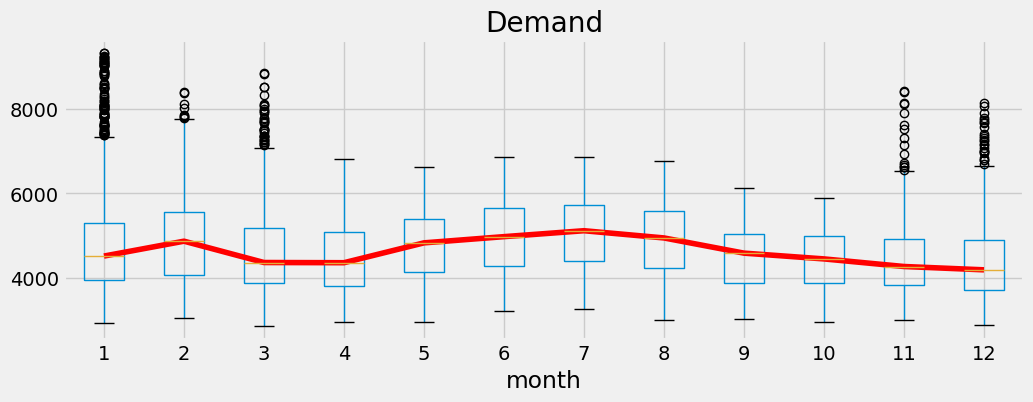

In [47]:
#Identity estacionalidad
fig, ax=plt.subplots(figsize=(12,4))
data['month'] =data.index.month
data.boxplot(column='Demand',by='month',ax=ax)
data.groupby('month')['Demand'].median().plot(ax=ax, color='red')
fig.suptitle('')

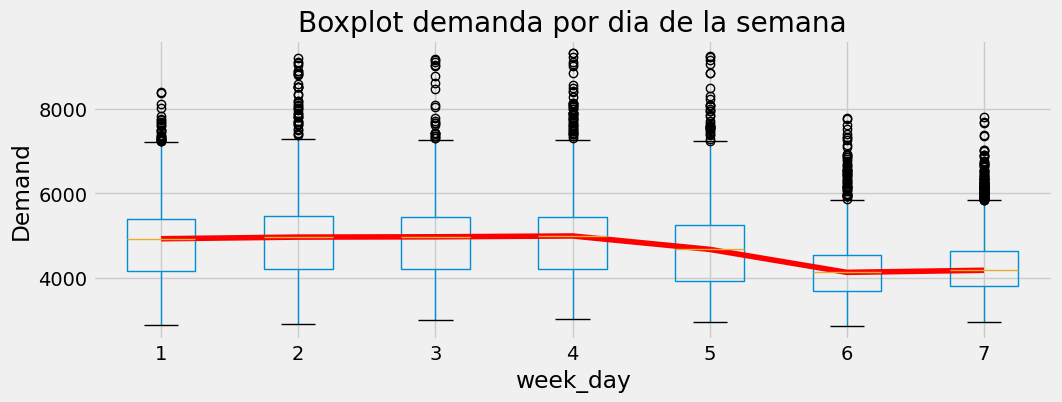

In [48]:
#Identificar estacionalidad semanal
fig,ax=plt.subplots(figsize=(12,4))
data['week_day']=data.index.day_of_week+1
data.boxplot(column='Demand',by='week_day',ax=ax)
data.groupby('week_day')['Demand'].median().plot(ax=ax,color='red')
ax.set_ylabel('Demand')
ax.set_title('Boxplot demanda por dia de la semana')
fig.suptitle('')
plt.show()

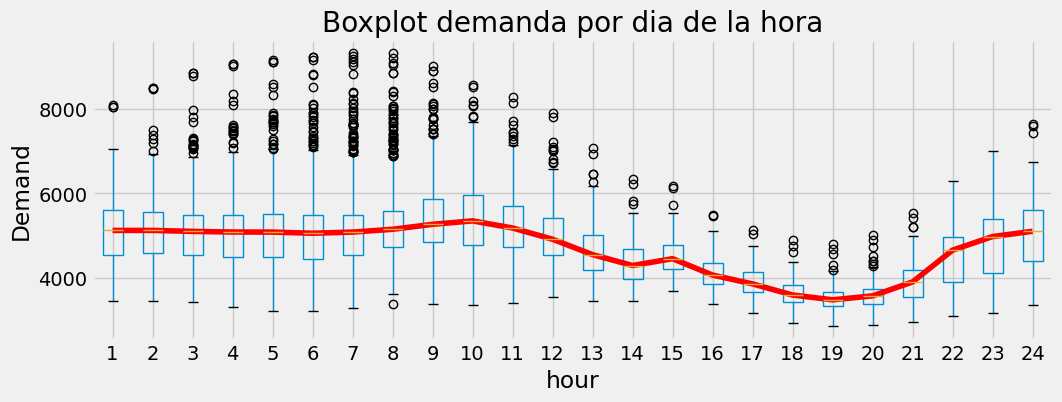

In [49]:
#Identificar estacionalidad hora
fig,ax=plt.subplots(figsize=(12,4))
data['hour']=data.index.hour+1
data.boxplot(column='Demand',by='hour',ax=ax)
data.groupby('hour')['Demand'].median().plot(ax=ax,color='red')
ax.set_ylabel('Demand')
ax.set_title('Boxplot demanda por dia de la hora')
fig.suptitle('')
plt.show()

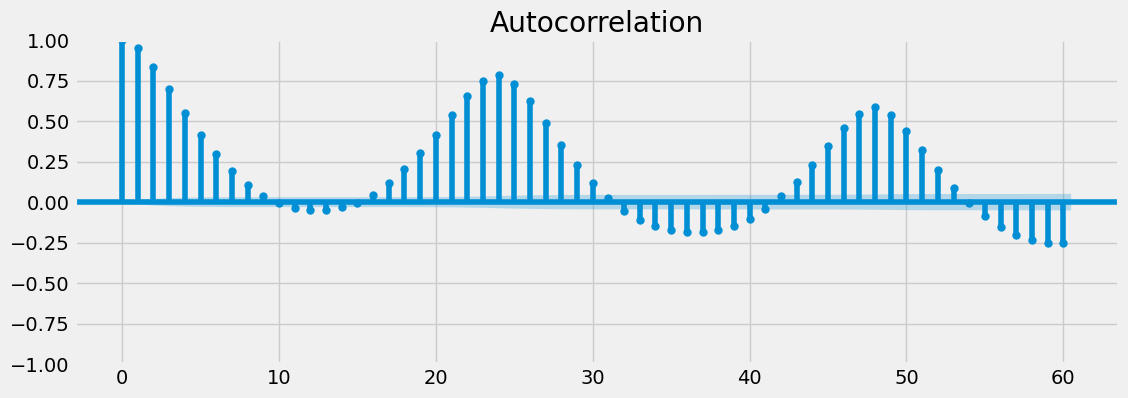

In [50]:
#Grafico de autocorrelacion
# Autocorelation mode la correalcion enre la serie y sus valores pasados
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(data['Demand'], lags=60, ax=ax)
plt.show()


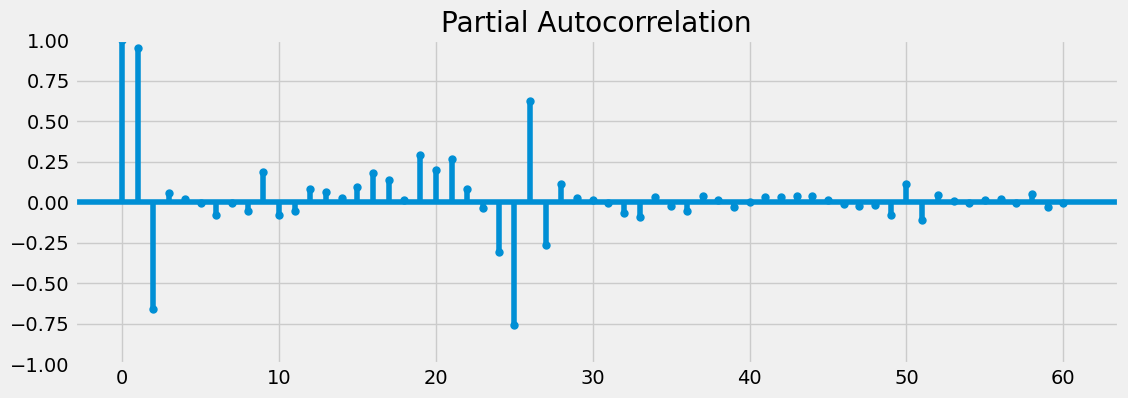

In [51]:
#Grafico de autocrrealcion parcial
# Autocorelation mode la correalcion enre la serie y sus valores pasados, despues de eliminar la correlacion de los valores intermedios
# Variacones explicacdas por valores pasados intermedios
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(data['Demand'], lags=60, ax=ax)
plt.show()


In [52]:
#Modelo de pronostico para la demanda
#Lags es el numero de valores pasados que se usaran para predecir el valor futuro
forecaster=ForecasterAutoreg(regressor=DecisionTreeRegressor(),
                             lags=24,
                             transformer_y=MinMaxScaler())
forecaster.fit(y=data_train['Demand'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: MinMaxScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2013-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-10-25 09:15:40 
Last fit date: 2024-10-25 09:15:41 
Skforecast version: 0.13.0 
Python version: 3.11.9 
Forecaster id: None 

In [53]:
#Backtesttin para ajustes fino del modelo
metrica,predicciones=backtesting_forecaster(forecaster=forecaster,
                                            y=data['Demand'],
                                           initial_train_size=len(data_train),
                                           fixed_train_size=False,
                                           refit=False,
                                           steps=24,
                                           metric=mean_absolute_error,
                                           verbose=True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 17544
Number of observations used for backtesting: 8713
    Number of folds: 364
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2013-12-31 23:00:00  (n=17544)
    Validation: 2014-01-01 00:00:00 -- 2014-01-01 23:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2014-01-02 00:00:00 -- 2014-01-02 23:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2014-01-03 00:00:00 -- 2014-01-03 23:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2014-01-04 00:00:00 -- 2014-01-04 23:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2014-01-05 00:00:00 -- 2014-01-05 23:00:00  (n=24)


  0%|          | 0/364 [00:00<?, ?it/s]

In [54]:
metrica

,mean_absolute_error
0,335.633918


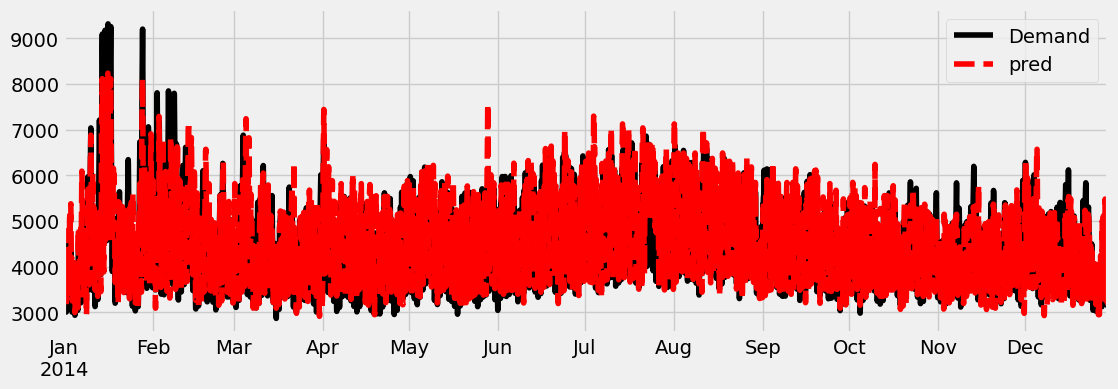

In [55]:
#Grafico de predicciones
fig, ax = plt.subplots(figsize=(12, 4))
data.loc[predicciones.index, 'Demand'].plot(ax=ax, label='Demand', color='black')
predicciones.plot(ax=ax, label='Predictions', color='red', ls='--')
ax.legend()

In [58]:
#Busqueda de hiperparametros
forecaster=ForecasterAutoreg(regressor=DecisionTreeRegressor(),
                             lags=24,
                             transformer_y=MinMaxScaler())
#Matriz de rezagos
lags_grid= [5,24,[1,2,3,23,24,25,47,48,49]]
param_grid={'max_depth':[3,5,7,9,12,15],
            'criterion':['squared_error','absolute_error']}

results=grid_search_forecaster(forecaster=forecaster,
                                y=data.loc[:test_end,'Demand'],
                                param_grid=param_grid,
                                lags_grid=lags_grid,
                                steps=24,
                                metric=mean_absolute_percentage_error,
                                refit=False,
                                initial_train_size=len(data_train),
                                fixed_train_size=False,
                                return_best=True,
                                verbose=True)

Number of models compared: 36.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 17544
Number of observations used for backtesting: 8016
    Number of folds: 334
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2013-12-31 23:00:00  (n=17544)
    Validation: 2014-01-01 00:00:00 -- 2014-01-01 23:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2014-01-02 00:00:00 -- 2014-01-02 23:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2014-01-03 00:00:00 -- 2014-01-03 23:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2014-01-04 00:00:00 -- 2014-01-04 23:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2014-01-05 00:00:00 -- 2014-01-05 23:00:00  (n=24)
Fold: 5
    Training:   No training in this 

In [59]:
results


,lags,lags_label,params,mean_absolute_percentage_error,criterion,max_depth
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 9}",0.069980,squared_error,9
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 7}",0.070939,absolute_error,7
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 15}",0.071273,squared_error,15
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 12}",0.072650,squared_error,12
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 15}",0.073348,absolute_error,15
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 9}",0.074193,absolute_error,9
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 7}",0.076256,squared_error,7
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 12}",0.081418,absolute_error,12
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 5}",0.084585,absolute_error,5
29,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 15}",0.095650,squared_error,15


In [61]:
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=9) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: MinMaxScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-10-25 09:16:36 
Last fit date: 2024-10-25 09:20:48 
Skforecast version: 0.13.0 
Python version: 3.11.9 
Forecaster id: None 

In [63]:
#Backtesttin para ajustes fino del modelo
metrica,predicciones=backtesting_forecaster(forecaster=forecaster,
                                            y=data['Demand'],
                                           initial_train_size=len(data_train),
                                           fixed_train_size=False,
                                           refit=False,
                                           steps=24,
                                           metric=mean_absolute_percentage_error,
                                           verbose=True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 17544
Number of observations used for backtesting: 8713
    Number of folds: 364
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2013-12-31 23:00:00  (n=17544)
    Validation: 2014-01-01 00:00:00 -- 2014-01-01 23:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2014-01-02 00:00:00 -- 2014-01-02 23:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2014-01-03 00:00:00 -- 2014-01-03 23:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2014-01-04 00:00:00 -- 2014-01-04 23:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2014-01-05 00:00:00 -- 2014-01-05 23:00:00  (n=24)


  0%|          | 0/364 [00:00<?, ?it/s]

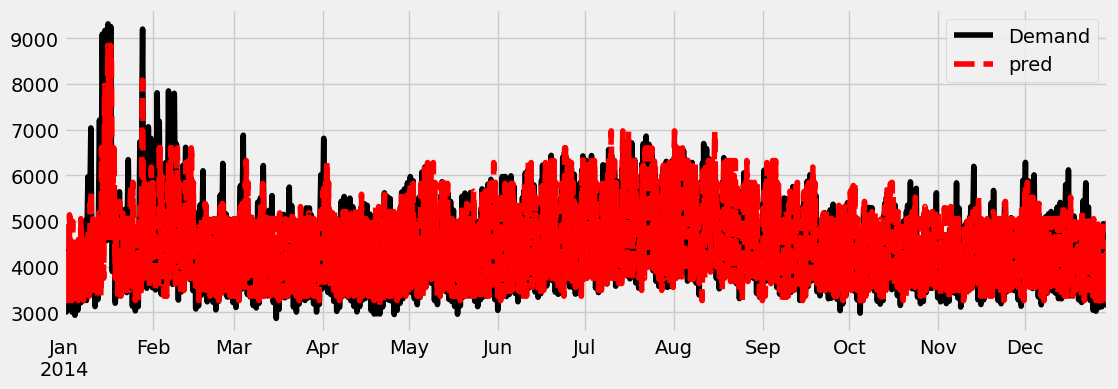

In [64]:
#Grafico de predicciones
fig, ax = plt.subplots(figsize=(12, 4))
data.loc[predicciones.index, 'Demand'].plot(ax=ax, label='Demand', color='black')
predicciones.plot(ax=ax, label='Predictions', color='red', ls='--')
ax.legend()

In [65]:
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.907805
23,lag_24,0.033439
19,lag_20,0.008957
2,lag_3,0.007515
1,lag_2,0.006787
17,lag_18,0.006681
10,lag_11,0.005265
12,lag_13,0.003529
8,lag_9,0.003147
4,lag_5,0.002657


In [66]:
forecaster.predict(720)

2014-12-01 00:00:00    5503.501419
2014-12-01 01:00:00    5388.030675
2014-12-01 02:00:00    5336.024692
2014-12-01 03:00:00    5336.024692
2014-12-01 04:00:00    5336.024692
                          ...     
2014-12-30 19:00:00    3722.799442
2014-12-30 20:00:00    4022.493905
2014-12-30 21:00:00    4910.559127
2014-12-30 22:00:00    5083.698539
2014-12-30 23:00:00    5350.181245
Freq: H, Name: pred, Length: 720, dtype: float64

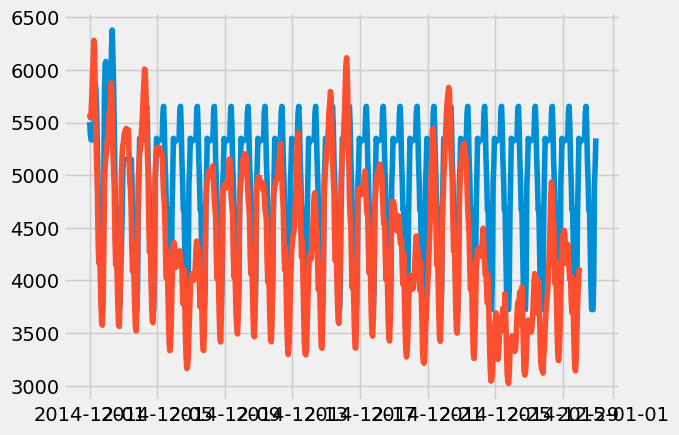

In [67]:
plt.plot(forecaster.predict(720))
plt.plot(data_val.Demand)
plt.show()